In [1]:
from astropy.table import Table
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM
import surveys
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng

In [2]:
# set up surveys
castor = surveys.CASTOR_Default()
lsst = surveys.Rubin_LSST100()
roman = surveys.Roman_HLWAS()
euclid = surveys.Euclid_EWS()

print("Five Sigma Point Source Depths")
for s in [castor, lsst, roman, euclid]:
    for f in s.filters:
        print(f.name, s.five_sigma_depth[f.name])
    print("\n")

Five Sigma Point Source Depths
castor_uv 27.46140876341312
castor_u 27.379737958769763
castor_g 27.032567209052182


LSST_u 26.515112323175543
LSST_g 27.62111474998568
LSST_r 27.155219468560716
LSST_i 26.716416356198938
LSST_z 26.12627814595358
LSST_y 25.27383575242886


Roman_106 26.564550153728735
Roman_129 26.74340158844503
Roman_158 26.620112120419265
Roman_184 26.19036009963334


Euclid_Y 24.31343675534767
Euclid_J 24.512613589417054
Euclid_H 24.486356086401454




In [3]:
cat = Table.read("unperturbed_mags.fits")
cat.info

<Table length=698211>
       name         dtype  unit    class     n_bad
------------------ ------- ---- ------------ -----
                ID   int64      MaskedColumn     0
                RA float64  deg       Column     0
               DEC float64  deg       Column     0
        ID_CLASSIC   int64      MaskedColumn     1
            photoz float64            Column     0
           lp_type   int64      MaskedColumn     0
         lp_NbFilt   int64      MaskedColumn     0
             lp_zq float64            Column     0
          lp_model   int64      MaskedColumn     0
            lp_age float64            Column     0
           lp_dust float64            Column     0
    lp_Attenuation   int64      MaskedColumn     0
       lp_mass_med float64            Column     0
      lp_mass_best float64            Column     0
        lp_SFR_med float64            Column     0
       lp_SFR_best float64      MaskedColumn   511
       lp_sSFR_med float64      MaskedColumn    23
      lp_

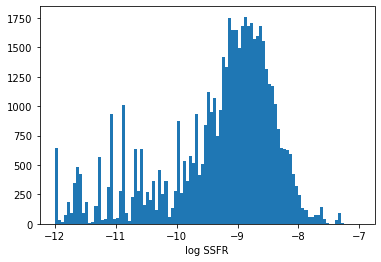

In [4]:
plt.hist(cat['lp_sSFR_med'][cat['lp_mass_med'] > 10], bins=100, range=(-12, -7))
plt.xlabel('log SSFR')
plt.show()
# looks like there is a bimodal distribution cleanly separated around log(ssfr) = -10.2

In [5]:
passive = cat['lp_sSFR_med'] <= -10.2
cat.add_column(passive, name='passive')

In [6]:
# uses relation from Kawinwanichakij et al 2021 Eq 2 and average values
def massToSize(logMass, alpha, beta, rp, logMp, delta=6, logsigma=0.17):
    Mratio = 10**(logMass - logMp)
    r = rp * (Mratio)**alpha * (0.5 * (1 + Mratio**delta))**((beta - alpha)/delta)
    # add scatter
    rng = default_rng()
    r = 10**(np.log10(r) + rng.standard_normal(r.size) * logsigma)
    # correct for any radii scattered to negative values
    r = np.abs(r)
    return r

In [7]:
r_kpc = np.zeros(len(cat))
r_kpc[cat['passive']] = massToSize(cat['lp_mass_med'][cat['passive']],
                                   alpha=0.10, beta=0.63, rp=1.9, logMp=10.3)
r_kpc[~cat['passive']] = massToSize(cat['lp_mass_med'][~cat['passive']],
                                   alpha=0.18, beta=0.39, rp=5.3, logMp=10.6)
r_kpc = r_kpc * u.kpc
print(np.median(r_kpc))
print(np.min(r_kpc))

2.1049903533213374 kpc
0.10768875409296146 kpc


In [8]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) 
aspk = cosmo.arcsec_per_kpc_proper(z=cat['photoz'])
hlr = (r_kpc * aspk).to(u.arcsec).value
print(np.median(hlr))
print(np.min(hlr))

0.31571519995509595
0.03211663578438495


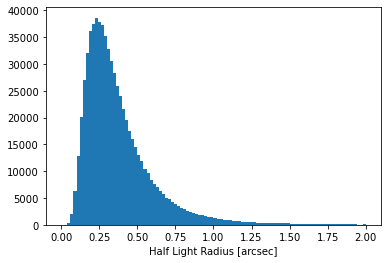

In [9]:
plt.hist(hlr, bins=100, range=(0,2))
plt.xlabel('Half Light Radius [arcsec]')
plt.show()

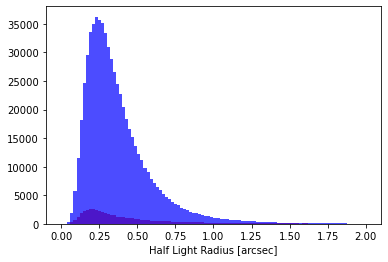

In [10]:
plt.hist(hlr[cat['passive']], bins=100, range=(0,2), color='red', alpha=0.7)
plt.hist(hlr[~cat['passive']], bins=100, range=(0,2), color='blue', alpha=0.7)
plt.xlabel('Half Light Radius [arcsec]')
plt.show()

In [11]:
# FWHM = 2 * hlr for gaussian
fwhm = 2 * hlr
#cat.add_column(fwhm, name='fwhm')
cat.add_column(hlr, name='hlr')

In [12]:
def make_magerr(cat, survey, mode='ext', gamma=0.04, sigma_sys=0.005):
    for f in survey.filters:
        mags = cat[f.name + '_MAG']
        
        if mode == 'ext':
            magerr = survey.calc_mag_err(mags, f.name, fwhm=2 * cat['hlr'])
        
        elif mode == 'm5':
            magerr = survey.calc_mag_err(mags, f.name, mode='m5')
                 
        else:
            raise ValueError("mode must be either 'snr' or 'm5'")
            
        magerr[magerr < sigma_sys] = sigma_sys
        cat[f.name + '_MAGERR'] = magerr
        


In [13]:
make_magerr(cat, lsst)
make_magerr(cat, euclid)
make_magerr(cat, castor)
make_magerr(cat, roman)

In [14]:
# remove this section to retain all objects
# add flag column
#mask = cat['Euclid_VIS_MAG'] < 24.5
mask = cat['LSST_i_MAG'] < lsst.five_sigma_depth["LSST_i"]
#mask = np.logical_and(cat['LSST_i_MAG'] < lsst.five_sigma_depth["LSST_i"],
#                      cat['LSST_z_MAG'] < lsst.five_sigma_depth["LSST_z"])
#mask = np.logical_and(mask, cat['LSST_r_MAG'] < lsst.five_sigma_depth["LSST_r"])

#print(np.sum(mask))
#mask = cat['photoz'] > 0
print(np.sum(mask))

505030


In [15]:
def plotErr(band, survey, mask):
    mag_col = band + "_MAG"
    err_col = band + "_MAGERR"
    gamma = 0.04
    sigma_sys = 0.005
    x = 10**(0.4 * (cat[mag_col] - survey.five_sigma_depth[band]))
    m5_magerr = np.sqrt(x * (0.04 - gamma) + gamma * x**2)
    m5_magerr[m5_magerr < sigma_sys] = sigma_sys
    plt.hexbin(cat[mag_col][mask], cat[err_col][mask], extent=(18,30,0,2), gridsize=(100,50), bins='log')
    plt.plot(cat[mag_col][mask], m5_magerr[mask], 'o', markersize=0.1, color='black', alpha=0.1)
    plt.ylim(0,2)
    plt.xlim(18,30)
    plt.colorbar()
    plt.xlabel('Unperturbed Mag')
    plt.ylabel('Mag Noise')
    plt.show()

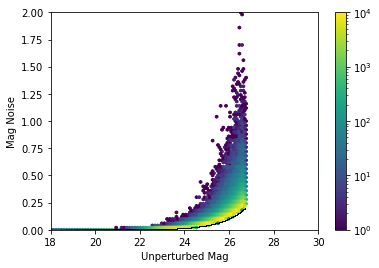

In [16]:
plotErr('LSST_i', lsst, mask)

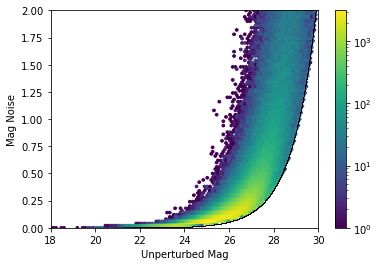

In [17]:
plotErr('castor_u', castor, mask)

In [18]:
newcat = cat.copy()
keep_filters = []
for s in [castor, lsst, euclid, roman]:
    for f in s.filters:
        keep_filters.append(f.name)
        
newcat.keep_columns(['ID', 'photoz', 'hlr'] + [f + "_MAG" for f in keep_filters] +
                    [f + "_MAGERR" for f in keep_filters])

# perturb photometry
for f in keep_filters:
    flux = 10**(-0.4 * (newcat[f + '_MAG'] + 48.6))
    snr = 2.5 / np.log(10) / newcat[f + '_MAGERR']
    noise = flux / snr
    rng = default_rng()
    error = rng.standard_normal(noise.size) * noise
    
    obs_flux = flux + error
    obs_mag = -2.5 * np.log10(obs_flux) - 48.6
    
    newcat[f + '_MAG'] = obs_mag

for f in castor.filters:
    newcat.add_column(cat[f.name + '_MAG'], name=f.name + '_UNPMAG')
    
newcat.write('ext_phot.fits', overwrite=True)

/tmp/ipykernel_190/98977212.py:19: RuntimeWarning: invalid value encountered in log10
  obs_mag = -2.5 * np.log10(obs_flux) - 48.6


STD of Mag Err at 5-sigma point source depth is:
0.34824129810517973


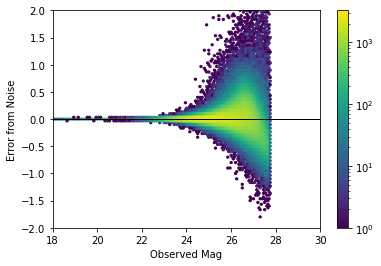

In [19]:
mask = newcat['LSST_i_MAG'] < lsst.five_sigma_depth["LSST_i"] + 1
plt.hexbin(newcat['LSST_i_MAG'][mask], cat['LSST_i_MAG'][mask] - newcat['LSST_i_MAG'][mask], 
           gridsize=(120, 60), extent=(18,30, -2,2), bins='log')
plt.colorbar()
plt.plot(np.arange(31), np.arange(31)*0, color='black', linewidth=1)
plt.xlim(18,30)
plt.ylim(-2,2)
plt.ylabel('Error from Noise')
plt.xlabel('Observed Mag')
magslice = np.abs(cat['LSST_i_MAG'] - lsst.five_sigma_depth["LSST_i"]) < 0.1
print("STD of Mag Err at 5-sigma point source depth is:")
print(np.nanstd(cat['LSST_i_MAG'][magslice] - newcat['LSST_i_MAG'][magslice]))

In [20]:
make_magerr(cat, lsst, mode='m5')
make_magerr(cat, euclid, mode='m5')
make_magerr(cat, castor, mode='m5')
make_magerr(cat, roman, mode='m5')

In [21]:
newcat = cat.copy()
keep_filters = []
for s in [castor, lsst, euclid, roman]:
    for f in s.filters:
        keep_filters.append(f.name)
        
newcat.keep_columns(['ID', 'photoz', 'hlr'] + [f + "_MAG" for f in keep_filters] +
                    [f + "_MAGERR" for f in keep_filters])

# perturb photometry
for f in keep_filters:
    flux = 10**(-0.4 * (newcat[f + '_MAG'] + 48.6))
    snr = 2.5 / np.log(10) / newcat[f + '_MAGERR']
    noise = flux / snr
    rng = default_rng()
    error = rng.standard_normal(noise.size) * noise
    
    obs_flux = flux + error
    obs_mag = -2.5 * np.log10(obs_flux) - 48.6
    
    newcat[f + '_MAG'] = obs_mag
    
for f in castor.filters:
    newcat.add_column(cat[f.name + '_MAG'], name=f.name + '_UNPMAG')
    
newcat.write('m5_phot.fits', overwrite=True)

/tmp/ipykernel_190/2287960068.py:19: RuntimeWarning: invalid value encountered in log10
  obs_mag = -2.5 * np.log10(obs_flux) - 48.6


STD of Mag Err at 5-sigma point source depth is:
0.2097033127723927


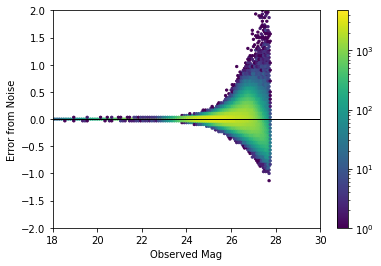

In [22]:
mask = newcat['LSST_i_MAG'] < lsst.five_sigma_depth["LSST_i"] + 1
plt.hexbin(newcat['LSST_i_MAG'][mask], cat['LSST_i_MAG'][mask] - newcat['LSST_i_MAG'][mask], 
           gridsize=(120, 60), extent=(18,30, -2,2), bins='log')
plt.colorbar()
plt.plot(np.arange(31), np.arange(31)*0, color='black', linewidth=1)
plt.xlim(18,30)
plt.ylim(-2,2)
plt.ylabel('Error from Noise')
plt.xlabel('Observed Mag')
magslice = np.abs(cat['LSST_i_MAG'] - lsst.five_sigma_depth["LSST_i"]) < 0.1
print("STD of Mag Err at 5-sigma point source depth is:")
print(np.nanstd(cat['LSST_i_MAG'][magslice] - newcat['LSST_i_MAG'][magslice]))

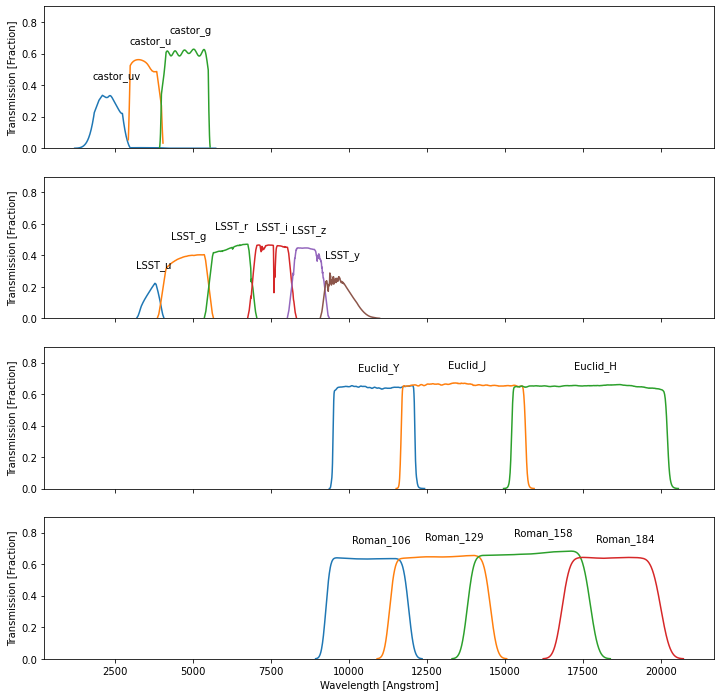

In [38]:
plt.rcParams['figure.figsize'] = [12,12]
fig, ax = plt.subplots(4, sharex=True)
plt.xlabel('Wavelength [Angstrom]')
i = -1
for s in [castor, lsst, euclid, roman]:
    i += 1
    for f in s.filters:
        ax[i].set_ylabel('Transmission [Fraction]')
        ax[i].plot(f.wl, f.response)
        ax[i].text(f.center - 500, np.max(f.response) + 0.1, f.name)
        ax[i].set_ylim(0, 0.9)
        

In [37]:
newcat.info

<Table length=698211>
      name        dtype     class     n_bad 
---------------- ------- ------------ ------
              ID   int64 MaskedColumn      0
          photoz float64       Column      0
   castor_uv_MAG float64       Column 109750
castor_uv_MAGERR float64       Column      0
    castor_u_MAG float64       Column  54378
 castor_u_MAGERR float64       Column      0
    castor_g_MAG float64       Column  20368
 castor_g_MAGERR float64       Column      0
      LSST_u_MAG float64       Column  70926
   LSST_u_MAGERR float64       Column      0
      LSST_g_MAG float64       Column  13009
   LSST_g_MAGERR float64       Column      0
      LSST_r_MAG float64       Column   5299
   LSST_r_MAGERR float64       Column      0
      LSST_i_MAG float64       Column   2367
   LSST_i_MAGERR float64       Column      0
      LSST_z_MAG float64       Column   4101
   LSST_z_MAGERR float64       Column      0
      LSST_y_MAG float64       Column  22326
   LSST_y_MAGERR float64       Co